# TRAIN TANPA OUTPUT PER LAYER

## Library

In [1]:
import os
import sys
import warnings
import matplotlib
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
from google.colab import files
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Pra-pemrosesan data

### Kompres gambar

In [ ]:
def compress(image_file,new_name):
  """
  PROSES KOMPRESI:
  1. Ambil path dari gambar
  2. Tentukan jumlah pixel maksimal untuk lebar gambar yang baru
  3. Hitung rasio gambar asli
  4. Hitung tinggi gambar yang baru dengan membagi jumlah pixel maksimal untuk lebar gambar yang baru dengan rasio gambar asli
  5. Ubah ukuran gambar menjadi hasil pembulatan dari lebar dan tinggi gambar yang baru
  6. Simpan gambar dengan kualitas 85% menggunakan image.save()
  """
  filepath = os.path.join(os.getcwd(),image_file)
  maxwidth = 512
  image = Image.open(filepath)
  width, height = image.size
  aspect_ratio = width/height
  new_height = maxwidth/aspect_ratio
  image = image.resize((maxwidth,round(new_height)))
  image.save(new_name,optimize=True,quality=85)
  return

In [ ]:
# BUAT DIRECTORY KOSONG
jenis = ['Train/','Test/']
spes = ['Anaphalis_javanica/','Leucogenes_grandiceps/','Leontopodium_alpinum/']

In [ ]:
# PROSES KOMPRESI GAMBAR
for item in jenis:
  # lakukan untuk setiap jenis peruntukan yaitu Train, Test, dan Validation
  for species in spes:
    # Lakukan untuk setiap spesies sehingga tiap jenis peruntukan punya tiga spesies
    so_path = str("/content/drive/MyDrive/Data Edelweiss/" + item + species)
    des_path = str("/content/drive/MyDrive/Data Edelweis Compressed 512/" + item + species)
    os.makedirs(des_path)                                             # Buat directory baru dari kombinasi jenis dan spesies
    files = os.listdir(so_path)                                       # List setiap file yg ada di source_path
    for file in files:
      raw_img_path = str(so_path + file)                            # Ambil path lengkap dari raw image
      compress(raw_img_path, str(des_path + "Compressed_" + file))  # Simpan dan beri nama baru yang berupa path lengkap dari destinasi penyimpanan + nama gambar
    print((item + species).ljust(35) + "[has been compressed]" )

Train/Anaphalis_javanica/          [has been compressed]
Train/Leucogenes_grandiceps/       [has been compressed]
Train/Leontopodium_alpinum/        [has been compressed]
Test/Anaphalis_javanica/           [has been compressed]
Test/Leucogenes_grandiceps/        [has been compressed]
Test/Leontopodium_alpinum/         [has been compressed]


### Buat train dan val generator

In [ ]:
TRAINING_DIR = '/content/drive/MyDrive/Data Edelweis Compressed 512/Train'
datagen = ImageDataGenerator(rescale=1./255.,
                                   validation_split = 0.2)                      # RGB itu nilai per pixelnya diantara [0,255],
train_generator = datagen.flow_from_directory(directory=TRAINING_DIR,           # jadi perlu dinormalisasikan dulu menjadi diantara [0,1]
                                                    batch_size=32,              # agar tidak terlalu besar
                                                    subset = "training",
                                                    class_mode="categorical",
                                                    target_size=(256,256))
val_generator =datagen.flow_from_directory(directory=TRAINING_DIR,
                                                subset = "validation",
                                                batch_size=32,
                                                class_mode="categorical",
                                                target_size=(256,256))
print(train_generator.class_indices)
print(val_generator.class_indices)

Found 2799 images belonging to 3 classes.
Found 699 images belonging to 3 classes.
{'Anaphalis_Javanica': 0, 'Leontopodium_Alpinum': 1, 'Leucogenes_Grandiceps': 2}
{'Anaphalis_Javanica': 0, 'Leontopodium_Alpinum': 1, 'Leucogenes_Grandiceps': 2}


In [ ]:
tf.keras.backend.clear_session()
print("Session Cleared")

Session Cleared


## Training Model

In [ ]:
main_path = "/content/drive/MyDrive/Hasil Program Skripsi/"
models_name = "10^-1"

### Buat arsitektur CNN

#### Model: Activation disatukan

In [ ]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(256, 256, 3)), #1
    tf.keras.layers.MaxPooling2D(2,2),                                                #2
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),                            #3
    tf.keras.layers.MaxPooling2D(2, 2),                                               #4
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),                            #5
    tf.keras.layers.MaxPooling2D(2, 2),                                               #6
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),                           #7
    tf.keras.layers.MaxPooling2D(2, 2),                                               #8
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),                           #9
    tf.keras.layers.MaxPooling2D(2, 2),                                               #10
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),                           #11
    tf.keras.layers.MaxPooling2D(2, 2),                                               #12

    tf.keras.layers.Flatten(),                                                        #13
    tf.keras.layers.Dense(128,activation='relu'),                                     #14
    tf.keras.layers.Dense(3, activation='softmax')                                    #15
    ])

# model.summary()
# tf.keras.utils.plot_model(model, to_file =f"{main_path}/All/Arsitektur model dense-1024.jpg" , show_shapes = True)

#### Model: activation dipisah

In [ ]:
tf.keras.backend.clear_session()

inputs = tf.keras.Input(shape = (256, 256, 3))
c1_conv = tf.keras.layers.Conv2D(16, (3, 3), activation=None)(inputs)
c1_relu = tf.keras.layers.Activation("relu")(c1_conv)
c1_pool = tf.keras.layers.MaxPooling2D(2,2)(c1_relu)

c2_conv = tf.keras.layers.Conv2D(32, (3, 3), activation=None)(c1_pool)
c2_relu = tf.keras.layers.Activation("relu")(c2_conv)
c2_pool = tf.keras.layers.MaxPooling2D(2, 2)(c2_relu)

c3_conv = tf.keras.layers.Conv2D(64, (3, 3), activation=None)(c2_pool)
c3_relu = tf.keras.layers.Activation("relu")(c3_conv)
c3_pool = tf.keras.layers.MaxPooling2D(2, 2)(c3_relu)

c4_conv = tf.keras.layers.Conv2D(128, (3, 3), activation=None)(c3_pool)
c4_relu = tf.keras.layers.Activation("relu")(c4_conv)
c4_pool = tf.keras.layers.MaxPooling2D(2, 2)(c4_relu)

c5_conv = tf.keras.layers.Conv2D(256, (3, 3), activation=None)(c4_pool)
c5_relu = tf.keras.layers.Activation("relu")(c5_conv)
c5_pool = tf.keras.layers.MaxPooling2D(2, 2)(c5_relu)

c6_conv = tf.keras.layers.Conv2D(256, (3, 3), activation=None)(c5_pool)
c6_relu = tf.keras.layers.Activation("relu")(c6_conv)
c6_pool = tf.keras.layers.MaxPooling2D(2, 2)(c6_relu)

FL = tf.keras.layers.Flatten()(c6_pool)
dense1 = tf.keras.layers.Dense(128,activation=None)(FL)
dense1_relu = tf.keras.layers.Activation("relu")(dense1)

dense2 = tf.keras.layers.Dense(3, activation=None)(dense1_relu)
dense2_soft = tf.keras.layers.Activation("softmax")(dense2)

### Proses Training

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.1)

file_name = " Performa model - Training.csv"
logger = tf.keras.callbacks.CSVLogger(f"{main_path+models_name+file_name}", separator=",", append=False)

model.compile(optimizer=opt,
              loss="categorical_crossentropy",
              metrics=["accuracy"])
history = model.fit(train_generator,
                    epochs=20,
                    validation_data=val_generator,
                    callbacks =[logger])

Epoch 1/20
88/88 [==============================] - 742s 8s/step - loss: 110861.6484 - accuracy: 0.3633 - val_loss: 1.1752 - val_accuracy: 0.3333
Epoch 2/20
88/88 [==============================] - 276s 3s/step - loss: 1.1099 - accuracy: 0.3394 - val_loss: 1.1156 - val_accuracy: 0.3333
Epoch 3/20
88/88 [==============================] - 274s 3s/step - loss: 1.1062 - accuracy: 0.3198 - val_loss: 1.1105 - val_accuracy: 0.3333
Epoch 4/20
88/88 [==============================] - 283s 3s/step - loss: 1.1039 - accuracy: 0.3401 - val_loss: 1.1140 - val_accuracy: 0.3333
Epoch 5/20
88/88 [==============================] - 267s 3s/step - loss: 1.1052 - accuracy: 0.3348 - val_loss: 1.0992 - val_accuracy: 0.3333
Epoch 6/20
88/88 [==============================] - 280s 3s/step - loss: 1.1067 - accuracy: 0.3333 - val_loss: 1.1233 - val_accuracy: 0.3333
Epoch 7/20
88/88 [==============================] - 280s 3s/step - loss: 1.1102 - accuracy: 0.3226 - val_loss: 1.1023 - val_accuracy: 0.3333
Epoch 8/

### Proses Plot Performa Model
Plotting performa model saat proses training

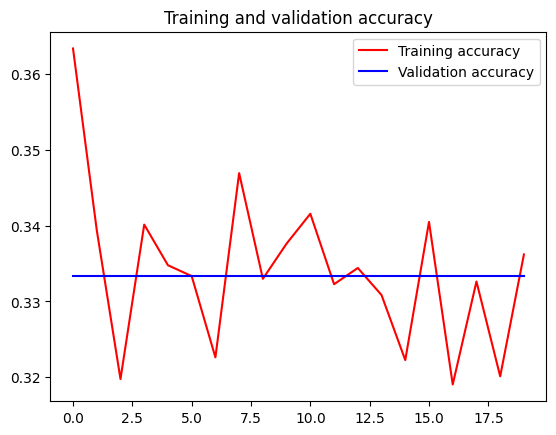

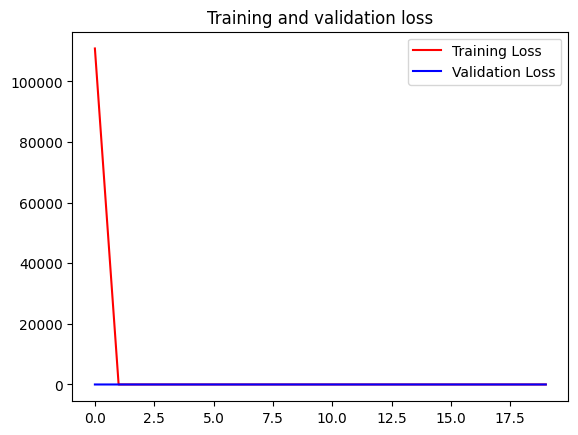

model sudah disimpan


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig(f"{main_path+models_name} Performa model - Training Accuracy")
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig(f"{main_path+models_name} Performa model - Training Loss")

plt.show()

model.save(f"{main_path+models_name} Model.keras")
print("model sudah disimpan")

## Testing

### Test dengan satu foto

In [ ]:
uploaded=files.upload()

for fn in uploaded.keys():

  # predicting images
  path='/content/' + fn
  img=load_img(path, target_size=(224, 224))

  img.show()

  x=img_to_array(img)
  x /= 255
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])

  classes = model_load.predict(images)

  print(classes)

### Test dengan satu folder

In [ ]:
TEST_DIR = "/content/drive/MyDrive/Data Edelweis Compressed 512/Test"
datagen = ImageDataGenerator(rescale=1./255.)
test_generator = datagen.flow_from_directory(directory=TEST_DIR,
                                            batch_size=32,
                                            class_mode="categorical",
                                            target_size=(256,256))

Found 1050 images belonging to 3 classes.


In [ ]:
def calculate_accuracy(model, test_generator):
  num_batches = len(test_generator)
  total_correct = 0

  for i in range(num_batches):
    batch_x, batch_y = test_generator[i]
    predictions = model.predict(batch_x)
    batch_correct = np.sum(np.argmax(predictions, axis=1) == np.argmax(batch_y, axis=1))
    print(f"Total prediksi benar pada batch ke-{i+1}: {batch_correct}")
    total_correct += batch_correct

  accuracy = total_correct / len(test_generator.labels)
  print("======================================================")
  print(f"Total benar: {total_correct}\nTotal salah: {1050-total_correct}")
  return accuracy

In [ ]:
for i in range(1,5):
  main_path = "/content/drive/MyDrive/Hasil Program Skripsi/"
  models_name = f"10^-{i}"
  model_load = tf.keras.models.load_model(f"{main_path+models_name} Model.keras")

  original_stdout = sys.stdout
  file_name = f"{models_name} Performa model - Dataset Test.txt"

  with open(main_path+file_name, 'w') as f:
    sys.stdout = f
    model_accuracy = calculate_accuracy(model_load, test_generator)
    print(f"Akurasi: {model_accuracy:.5f}")
    sys.stdout = original_stdout
  print("Testing selesai dan sudah disimpan di:")
  print(file_name,"\n=======================================")

Testing selesai dan sudah disimpan di:
10^-1 Performa model - Dataset Test.txt 
Testing selesai dan sudah disimpan di:
10^-2 Performa model - Dataset Test.txt 
Testing selesai dan sudah disimpan di:
10^-3 Performa model - Dataset Test.txt 
Testing selesai dan sudah disimpan di:
10^-4 Performa model - Dataset Test.txt 


In [ ]:
def define_labels(labels):
  if labels == 0:
    labels_name =  "Anaphalis javanica"
  elif labels == 1:
    labels_name = "Leontopodium alpinum"
  else:
    labels_name = "Leucogenes grandiceps"
  return labels_name

for i in range(1,5):        # Karena lr = 1,2,3,4 jadi range nya (1,5)
  main_path = "/content/drive/MyDrive/Hasil Program Skripsi/"
  models_name = f"10^-{i}"

  tf.keras.backend.clear_session()
  model_load = tf.keras.models.load_model(f"{main_path+models_name} Model.keras")

  images, labels = next(test_generator)
  predicted_labels = model_load.predict(images)

  # Label kelas aktual dan label kelas hasil prediksi
  actual_labels = np.argmax(labels, axis=1)
  predicted_labels = np.argmax(predicted_labels, axis=1)

  # Plot hasil untuk 10 gambar pertama
  plt.figure(figsize=(40, 50))
  for i in range(32):
    plt.subplot(7, 5, i + 1)
    plt.imshow(images[i])
    plt.axis('off')
    if actual_labels[i] == predicted_labels[i]:
      plt.title(f"Prediksi: {define_labels(predicted_labels[i])} \nAktual: {define_labels(actual_labels[i])}", color='green')
    else:
      plt.title(f"Prediksi: {define_labels(predicted_labels[i])} \nAktual: {define_labels(actual_labels[i])}", color='red')
  plt.tight_layout()
  plt.savefig(f"{main_path+models_name} Gambar contoh prediksi")

# MENGGABUNGKAN GRAFIK
Empat model dg learning rate yang berbeda
```
lr = 10^-i, i=1,2,3,4
```

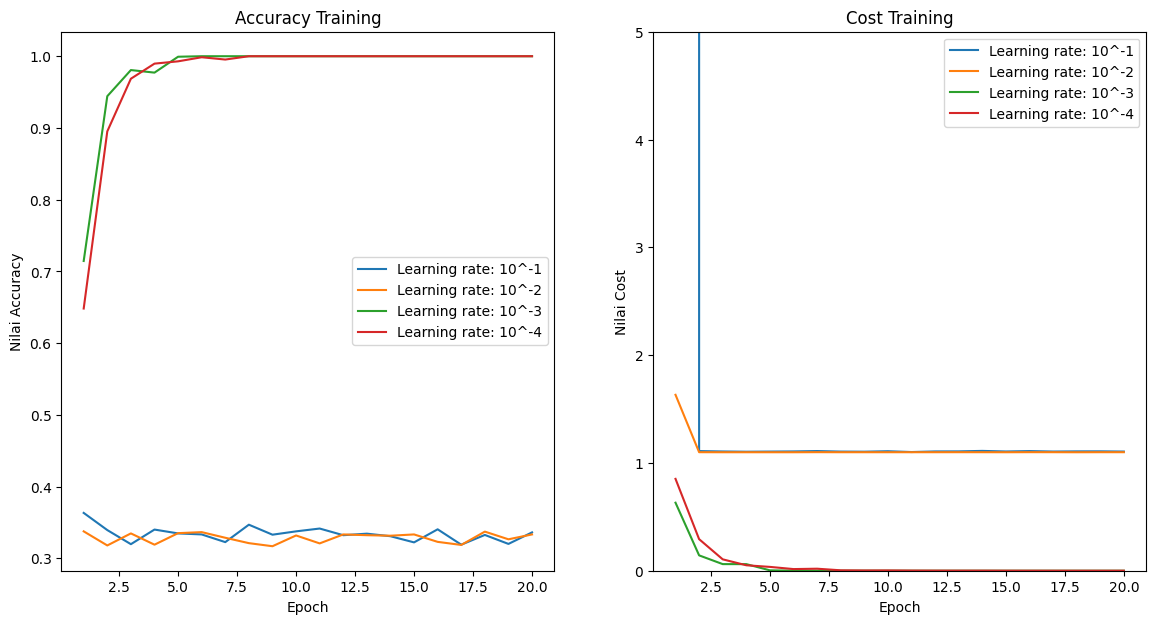

In [ ]:
# Fungsi untuk membaca data dari file CSV
def read_data(file_name):
  return pd.read_csv(file_name)

# Membaca data dari empat file CSV
file1 = "/content/drive/MyDrive/Hasil Program Skripsi/10^-1 Performa model - Training.csv"
file2 = "/content/drive/MyDrive/Hasil Program Skripsi/10^-2 Performa model - Training.csv"
file3 = "/content/drive/MyDrive/Hasil Program Skripsi/10^-3 Performa model - Training.csv"
file4 = "/content/drive/MyDrive/Hasil Program Skripsi/10^-4 Performa model - Training.csv"

file_names = [file1, file2, file3, file4]
data_frames = [read_data(file_name) for file_name in file_names]

# Memeriksa apakah setiap file memiliki kolom "Val_accuracy" dan "Val_cost"
for df in data_frames:
  if 'Val_accuracy' not in df.columns or 'Val_cost' not in df.columns:
    raise ValueError("CSV files must contain 'Val_accuracy' and 'Val_cost' columns")

# Membuat plot untuk accuracy
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
for i, df in enumerate(data_frames):
  plt.plot(range(1, len(df) + 1), df['Accuracy'], label=f'Learning rate: 10^-{i+1}') #Ubah
plt.title('Accuracy Training')  #Ubah
plt.xlabel('Epoch')
plt.ylabel('Nilai Accuracy')
plt.legend()

# Membuat plot untuk loss
plt.subplot(1, 2, 2)
for i, df in enumerate(data_frames):
  plt.plot(range(1, len(df) + 1), df['Cost'], label=f'Learning rate: 10^-{i+1}') #Ubah
plt.title('Cost Training')  #Ubah
plt.xlabel('Epoch')
plt.ylabel('Nilai Cost')
plt.ylim(0, 5)
plt.legend()

plt.savefig("/content/drive/MyDrive/Hasil Program Skripsi/All/All - Akurasi dan Cost Training.png") #Ubah
plt.show()


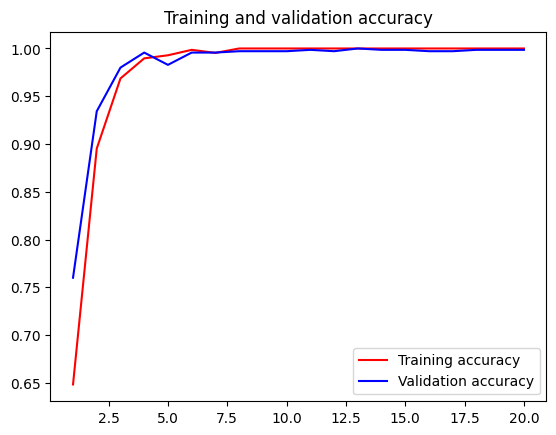

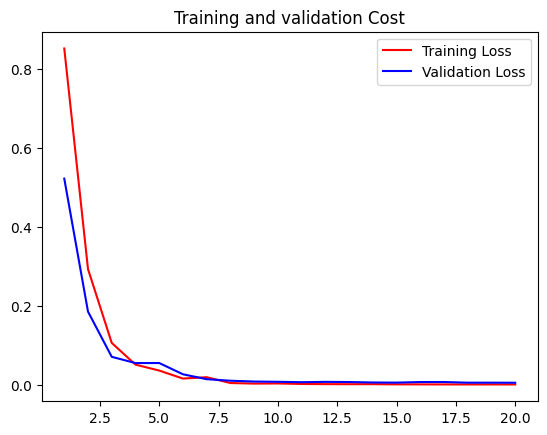

In [ ]:
def read_data(file_name):
  return pd.read_csv(file_name)

main_path = "/content/drive/MyDrive/Hasil Program Skripsi/"
models_name = "10^-4"
df = read_data(f"{main_path+models_name} Performa model - Training.csv")

acc = df['Accuracy']
val_acc = df['Val_accuracy']
Cost = df['Cost']
val_cost = df['Val_cost']

epochs = range(1,len(acc)+1)

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig(f"{main_path+models_name} Performa model - Training Accuracy")
plt.figure()

plt.plot(epochs, Cost, 'r', label='Training Loss')
plt.plot(epochs, val_cost, 'b', label='Validation Loss')
plt.title('Training and validation Cost')
plt.legend()
plt.savefig(f"{main_path+models_name} Performa model - Training Cost")

plt.show()

# model.save(f"{main_path+models_name} Model.keras")
# print("model sudah disimpan")

# OUTPUT PERHITUNGAN PER LAYER

## Cek filter dan bias layer terakhir

In [ ]:
def bias_checking(model):
  tf.keras.backend.clear_session()
  model_new = tf.keras.Model(inputs = inputs, outputs=dense2_soft)

  for i in range(2):
    trainable_param = model_new.layers[i].get_weights()
    if len(trainable_param) == 2:
      filters, bias = trainable_param
      print(f"Bias:\n{bias}")

def show_params(model):
  last_layer = len(model.layers)-1
  trainable_param = model.layers[last_layer].get_weights()
  print("\nooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo")
  if len(trainable_param) == 2:
    filters, bias = trainable_param
    print(f"layer {model.layers[last_layer].name}\t Dimensi w: {filters.shape}\t Dimensi bias: {bias.shape}")
    print(f"Weight:\n{filters}\nBias:\n{bias}")
  elif len(trainable_param) == 1:
    filters = trainable_param[0]
    print(f"layer {model.layers[last_layer].name}\t Dimensi: {filters.shape}")
    print(f"Weight:\n{filters}")
  else:
    print(f"layer {model.layers[last_layer].name}\t Tidak ada parameter yang dapat dilatih")
  print("\nooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo")

In [ ]:
tf.keras.backend.clear_session()

inputs = tf.keras.Input(shape = (256, 256, 3))
c1_conv = tf.keras.layers.Conv2D(16, (3, 3), activation=None)(inputs)
c1_relu = tf.keras.layers.Activation("relu")(c1_conv)
c1_pool = tf.keras.layers.MaxPooling2D(2,2)(c1_relu)

c2_conv = tf.keras.layers.Conv2D(32, (3, 3), activation=None)(c1_pool)
c2_relu = tf.keras.layers.Activation("relu")(c2_conv)
c2_pool = tf.keras.layers.MaxPooling2D(2, 2)(c2_relu)

c3_conv = tf.keras.layers.Conv2D(64, (3, 3), activation=None)(c2_pool)
c3_relu = tf.keras.layers.Activation("relu")(c3_conv)
c3_pool = tf.keras.layers.MaxPooling2D(2, 2)(c3_relu)

c4_conv = tf.keras.layers.Conv2D(128, (3, 3), activation=None)(c3_pool)
c4_relu = tf.keras.layers.Activation("relu")(c4_conv)
c4_pool = tf.keras.layers.MaxPooling2D(2, 2)(c4_relu)

c5_conv = tf.keras.layers.Conv2D(256, (3, 3), activation=None)(c4_pool)
c5_relu = tf.keras.layers.Activation("relu")(c5_conv)
c5_pool = tf.keras.layers.MaxPooling2D(2, 2)(c5_relu)

c6_conv = tf.keras.layers.Conv2D(256, (3, 3), activation=None)(c5_pool)
c6_relu = tf.keras.layers.Activation("relu")(c6_conv)
c6_pool = tf.keras.layers.MaxPooling2D(2, 2)(c6_relu)

FL = tf.keras.layers.Flatten()(c6_pool)
dense1 = tf.keras.layers.Dense(128,activation=None)(FL)
dense1_relu = tf.keras.layers.Activation("relu")(dense1)

dense2 = tf.keras.layers.Dense(3, activation=None)(dense1_relu)
dense2_soft = tf.keras.layers.Activation("softmax")(dense2)

## Input feature map

### Dari datagen

#### Menampilkan seluruh tensor di tiap dataset

In [ ]:
TRAINING_DIR = '/content/drive/MyDrive/Data Edelweis Compressed 512/Train'
datagen = ImageDataGenerator(rescale=1./255.,
    validation_split = 0.2)                      # RGB itu nilai per pixelnya diantara [0,255],
train_generator = datagen.flow_from_directory(directory=TRAINING_DIR,           # jadi perlu dinormalisasikan dulu menjadi diantara [0,1]
                                                    batch_size=32,              # agar tidak terlalu besar
                                                    subset = "training",
                                                    class_mode="categorical",
                                                    target_size=(256,256))
val_generator =datagen.flow_from_directory(directory=TRAINING_DIR,
                                                subset = "validation",
                                                batch_size=32,
                                                class_mode="categorical",
                                                target_size=(256,256))
TEST_DIR = "/content/drive/MyDrive/Data Edelweis Compressed 512/Test"
datagen = ImageDataGenerator(rescale=1./255.)
test_generator = datagen.flow_from_directory(directory=TEST_DIR,
                                            batch_size=32,
                                            class_mode="categorical",
                                            target_size=(256,256))

Found 2799 images belonging to 3 classes.
Found 699 images belonging to 3 classes.
Found 1050 images belonging to 3 classes.


In [ ]:
def display_tensors(generator):
  total_tensor = generator.n
  batch_size = generator.batch_size
  mini_batches = int(np.ceil(total_tensor/batch_size))
  for batch_num in range(mini_batches):
    print(f"Mini batch ke-{batch_num + 1}:")
    images, labels = next(generator)
    for i in range(len(images)):
      print(f"Tensor ke-{i+1} di mini-batch ke-{batch_num + 1}:")
      print(images[i])
      if batch_num == 0 and i == 0:
        first_image_index = generator.index_array[0]
        first_image_filename = generator.filepaths[first_image_index]
      print("---------------------------------------------------------------------")
    print("=====================================================================")
  return first_image_filename

In [ ]:
original_stdout = sys.stdout
path = "/content/drive/MyDrive/Hasil Program Skripsi/All/"
dataset = ["train", 'validation', "test"]
generator = [train_generator,val_generator,test_generator]

for i in range(len(dataset)):
  file_name = f"Tensor dataset {dataset[i]} di setiap mini batch.txt"
  with open(path+file_name, 'w') as f:
    sys.stdout = f
    if i == 0:
      first_image = display_tensors(generator[i])
    else:
      result = display_tensors(generator[i])
    sys.stdout = original_stdout
  print(f"Tensor dataset {dataset[i]} di setiap mini batch.txt telah disimpan")

print(f"\nPath gambar pertama di dataset train:\n{first_image}" )

Tensor dataset train di setiap mini batch.txt telah disimpan
Tensor dataset validation di setiap mini batch.txt telah disimpan
Tensor dataset test di setiap mini batch.txt telah disimpan

Path gambar pertama di dataset train:
/content/drive/MyDrive/Data Edelweis Compressed 512/Train/Anaphalis_Javanica/Compressed512_Anaphalis_Javanica_398.png


### Satu Gambar

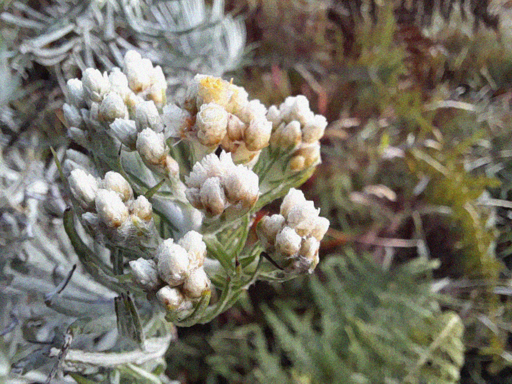

In [11]:
path = "/content/drive/MyDrive/Data Edelweis Compressed 512/Train/Anaphalis_Javanica/Compressed512_Anaphalis_Javanica_398.png"
img = tf.keras.utils.load_img(path)
img

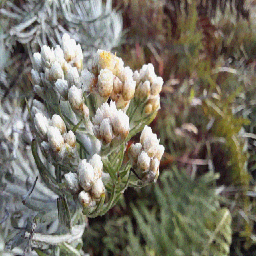

In [12]:
img = tf.keras.utils.load_img(path, target_size = (256,256))
img

In [13]:
np.set_printoptions(threshold=None)
np.set_printoptions(precision = 12,formatter={'float': '{:0.12f}'.format})

img = tf.keras.utils.img_to_array(img)
img = img.reshape((1, 256, 256, 3))
img_norm = img / 255.

In [37]:
# [0,baris,kolom,warna], <-1:> elemen terkahir
# print(img[0, 0, (0,1,-1), :])
# print(img[0, 3, (0,1,-1), :])
# print(img[0, -1:, (0,1,-1), :])
print("\n====================================================================\n")
print(img_norm[0, 0, (0,1,-1), :])
print("-----------------------------")
print(img_norm[0, 3, (0,1,-1), :])
# print(img_norm[0, -1:, (0,1,-1), :])



[[0.501960813999 0.568627476692 0.498039215803]
 [0.498039215803 0.501960813999 0.372549027205]
 [0.537254929543 0.419607847929 0.298039227724]]
-----------------------------
[[0.368627458811 0.396078437567 0.250980407000]
 [0.415686279535 0.396078437567 0.356862753630]
 [0.454901963472 0.384313732386 0.290196090937]]


In [38]:
0.502*(-0.079)+0.498*0.07+0.482*(-0.169)+0.388*0.112+0.341*(-0.164)+0.502*0.151+0.608*0.04+0.584*(-0.15)+0.647*(-0.095)+0.569*(-0.075)+0.502*0.039+0.486*(-0.175)
+0.463*0.025+0.384*(-0.131)+0.537*0.142+0.655*0.038+0.663*0.135+0.757*0.067+0.498*(-0.187)+0.373*(-0.137)+0.396*(-0.155)
+0.318*0.007+0.325*(-0.11)+0.411*(-0.168)+0.525*0.025+ 0.557*(-0.039)+0.71*0.130


-0.018870000000000012

In [35]:
A = [1,2,3,4,5,6,7,8]
print(A[:3])    # [1, 2, 3]: tiga pertama
print(A[3:])    # [4, 5, 6, 7, 8]: setelah elemen ke tiga
print(A[:-1])   # [1, 2, 3, 4, 5, 6, 7]: sebelum elemen terakhir
print(A[-1:])   # [8]: elemen terakhir
print(A[2])

[1, 2, 3]
[4, 5, 6, 7, 8]
[1, 2, 3, 4, 5, 6, 7]
8
3


## Save Output

In [ ]:
original_stdout = sys.stdout
path = "/content/drive/MyDrive/Hasil Program Skripsi/All/"
file_name = "Output perhitungan per layer.txt"

tf.keras.backend.clear_session()

with open(path+file_name, 'w') as f:
  sys.stdout = f
  np.set_printoptions(precision = 12, threshold=None, formatter={'float': '{:0.12f}'.format})

  print(f"Xtn_1 = {img}")
  # Convolution pertama
  c1_model = tf.keras.Model(inputs = inputs, outputs=[c1_conv])
  show_params(c1_model)
  c1_model_pred = tf.keras.Model(inputs = inputs, outputs=[c1_conv,c1_relu])
  pre, post = c1_model_pred.predict(img)
  # Output
  print(f"\nA^(1) = {post}\nDimensi A^(1) = {post.shape}")
  #Pool
  pool1_model = tf.keras.Model(inputs = inputs, outputs=[c1_pool])
  pool_output = pool1_model.predict(img)
  print(f"\nP^(2) ={pool_output}\nDimensi {pool_output.shape}")

  # Convolution kedua
  c2_model = tf.keras.Model(inputs = inputs, outputs=[c2_conv])
  show_params(c2_model)
  c2_model_pred = tf.keras.Model(inputs = inputs, outputs=[c2_conv,c2_relu])
  pre, post = c2_model_pred.predict(img)
  # Output
  print(f"\nA^(3) = {post}\nDimensi A^(3) = {post.shape}")
  #Pool
  pool2_model = tf.keras.Model(inputs = inputs, outputs=[c2_pool])
  pool_output = pool2_model.predict(img)
  print(f"\nP^(4) = {pool_output}\nDimensi {pool_output.shape}")

  # Convolution ketiga
  c3_model = tf.keras.Model(inputs = inputs, outputs=[c3_conv])
  show_params(c3_model)
  c3_model_pred = tf.keras.Model(inputs = inputs, outputs=[c3_conv,c3_relu])
  pre, post = c3_model_pred.predict(img)
  # Output
  print(f"\nA^(5) = {post}\nDimensi A^(5) = {post.shape}")
  #Pool
  pool3_model = tf.keras.Model(inputs = inputs, outputs=[c3_pool])
  pool_output = pool3_model.predict(img)
  print(f"\nP^(6) = {pool_output}\nDimensi {pool_output.shape}")

  # Convolution keempat
  c4_model = tf.keras.Model(inputs = inputs, outputs=[c4_conv])
  show_params(c4_model)
  c4_model_pred = tf.keras.Model(inputs = inputs, outputs=[c4_conv,c4_relu])
  pre, post = c4_model_pred.predict(img)
  # Output
  print(f"\nA^(7) = {post}\nDimensi A^(7) = {post.shape}")
  #Pool
  pool4_model = tf.keras.Model(inputs = inputs, outputs=[c4_pool])
  pool_output = pool4_model.predict(img)
  print(f"\nP^(8) = {pool_output}\nDimensi {pool_output.shape}")

  # Convolution kelima
  c5_model = tf.keras.Model(inputs = inputs, outputs=[c5_conv])
  show_params(c5_model)
  c5_model_pred = tf.keras.Model(inputs = inputs, outputs=[c5_conv,c5_relu])
  pre, post = c5_model_pred.predict(img)
  # Output
  print(f"\nA^(9) = {post}\nDimensi A^(9) = {post.shape}")
  #Pool
  pool5_model = tf.keras.Model(inputs = inputs, outputs=[c5_pool])
  pool_output= pool5_model.predict(img)
  print(f"\nP^(10) = {pool_output}\nDimensi {pool_output.shape}")

  # Convolution keenam
  c6_model = tf.keras.Model(inputs = inputs, outputs=[c6_conv])
  show_params(c6_model)
  c6_model_pred = tf.keras.Model(inputs = inputs, outputs=[c6_conv,c6_relu])
  pre, post = c6_model_pred.predict(img)
  # Output
  print(f"\nA^(11) = {post}\nDimensi ^(11) = {post.shape}")
  #Pool
  pool6_model = tf.keras.Model(inputs = inputs, outputs=[c6_pool])
  pool_output= pool6_model.predict(img)
  print(f"\nP^(12) = {pool_output}\nDimensi {pool_output.shape}")

  #Fully-connected
  FL_model = tf.keras.Model(inputs = inputs, outputs=[FL])
  output = FL_model.predict(img)
  print(f"\nzf = {output}")
  print(f"Dimensi : {output.shape}")

  dense1_model = tf.keras.Model(inputs = inputs, outputs=[dense1])
  show_params(dense1_model)
  dense1_model = tf.keras.Model(inputs = inputs, outputs=[dense1,dense1_relu])
  pre, post = dense1_model.predict(img)
  print(f"\nzdj^(14) = {pre}\nd^(14) = {post}")

  dense2_model = tf.keras.Model(inputs = inputs, outputs=dense2)
  show_params(dense2_model)
  dense2_model = tf.keras.Model(inputs = inputs, outputs=[dense2,dense2_soft])
  pre, post = dense2_model.predict(img)
  print(f"\nzdj^(15) = {pre}\nd^(15) = {post}")

  sys.stdout = original_stdout
print("Proses selesai")

Proses selesai


In [ ]:
bias_checking(dense2_model)

Bias:
[0.000000000000 0.000000000000 0.000000000000 0.000000000000
 0.000000000000 0.000000000000 0.000000000000 0.000000000000
 0.000000000000 0.000000000000 0.000000000000 0.000000000000
 0.000000000000 0.000000000000 0.000000000000 0.000000000000]


## Loss dan Update parameter

In [ ]:
class AdamOptimizer:
  def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
    self.learning_rate = learning_rate
    self.beta1 = beta1
    self.beta2 = beta2
    self.epsilon = epsilon
    self.m = None
    self.v = None
    self.t = 0

  def minimize(self, gradients, variables):
    if self.m is None:
      self.m = [np.zeros_like(grad) for grad in gradients]
      self.v = [np.zeros_like(grad) for grad in gradients]

    self.t += 1
    m_hat = []
    v_hat = []
    updates = []

    for i, grad in enumerate(gradients):
      # Update m and v
      self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * grad
      self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (grad ** 2)

      # Compute m_hat and v_hat
      mhat_m = self.m[i] / (1 - self.beta1 ** self.t)
      vhat_v = self.v[i] / (1 - self.beta2 ** self.t)
      m_hat.append(mhat_m)
      v_hat.append(vhat_v)

      # Compute update
      update = -self.learning_rate * m_hat[i] / (np.sqrt(v_hat[i]) + self.epsilon)
      updates.append(update)

    # Apply updates to variables
    for var, update in zip(variables, updates):
      var.assign_sub(update)

class AdamOptimizerShow:
  def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
    self.learning_rate = learning_rate
    self.beta1 = beta1
    self.beta2 = beta2
    self.epsilon = epsilon
    self.m = None
    self.v = None
    self.t = 0

  def minimize(self, gradients, variables):
    if self.m is None:
      self.m = [np.zeros_like(grad) for grad in gradients]
      self.v = [np.zeros_like(grad) for grad in gradients]

    self.t += 1
    m_hat = []
    v_hat = []
    updates = []

    for i, grad in enumerate(gradients):
      print("=============================================================================================")
      tf.print(f"{variables[i].name} dengan dimensi {variables[i].shape} \nSebelum Adam:\n", variables[i])

      self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * grad
      self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (grad ** 2)

      mhat_m = self.m[i] / (1 - self.beta1 ** self.t)
      vhat_v = self.v[i] / (1 - self.beta2 ** self.t)
      m_hat.append(mhat_m)
      v_hat.append(vhat_v)

      update = -self.learning_rate * m_hat[i] / (np.sqrt(v_hat[i]) + self.epsilon)
      updates.append(update)

      # print
      tf.print("g_1:", grad)
      tf.print("m_1:", self.m[i])
      tf.print("v_1:", self.v[i])
      tf.print("m_topi_1:", mhat_m)
      tf.print("v_topi_1:", vhat_v)
      tf.print("setelah Adam:", update)

    for var, update in zip(variables, updates):
      var.assign_sub(update)

In [ ]:
original_stdout = sys.stdout
train_generator.reset()
val_generator.reset()
test_generator.reset()

path = "/content/drive/MyDrive/Hasil Program Skripsi/All/"
file_name = "Output perhitungan Loss dan Cost dalam satu Epoch.txt"
model = tf.keras.Model(inputs = inputs, outputs = dense2_soft)
optimizer_show = AdamOptimizerShow()
optimizer = AdamOptimizer()

epochs = 1
steps_per_epoch = 88
validation_steps = 22
total_predictions = 0
total_correct_predictions = 0

with open(path+file_name, 'w') as f:
  sys.stdout = f
  for epoch in range(epochs):
    print("=======================")
    print("     DATASET TRAIN     ")
    print("=======================")
    for step in range(steps_per_epoch):
      # Training
      x_batch, y_batch = train_generator.next()
      with tf.GradientTape() as tape:
        predictions = model(x_batch)
        loss = tf.keras.losses.categorical_crossentropy(y_true=y_batch, y_pred=predictions)
        for i in range(len(loss)):
          print(f"mini batch {step+1}, Gambar {i+1} = {loss[i]}")

        pred_labels = tf.argmax(predictions, axis=1)
        true_labels = tf.argmax(y_batch, axis=1)
        correct_predictions = tf.reduce_sum(tf.cast(pred_labels == true_labels, tf.float32))
        total_correct_predictions += correct_predictions.numpy()
        total_predictions += len(x_batch)
        print(f"\nmini batch {step + 1}/{steps_per_epoch} - Cost: {loss.numpy().mean():.4f}")
        print(f"mini batch {step + 1}/{steps_per_epoch} - Jumlah prediksi benar: {correct_predictions.numpy()}")
        print("-----------------------------------------------------------")

        # Update Parameter: Hanya ditampilkan pada batch dan epoch pertama
        gradients = tape.gradient(loss, model.trainable_variables)
        if step == 0 and epoch == 0:
          optimizer_show.minimize(gradients, model.trainable_variables)
        else:
          optimizer.minimize(gradients, model.trainable_variables)
    total_train_accuracy = total_correct_predictions / total_predictions
    print(f"TRAIN ACCURACY: {total_train_accuracy:.4f}")

    # Validation
    print("\n======================")
    print("  DATASET VALIDATION ")
    print("======================")
    total_val_accuracy = 0
    total_correct_predictions = 0
    total_predictions = 0

    for step in range(validation_steps):
      x_val_batch, y_val_batch = val_generator.next()
      with tf.GradientTape() as tape:
        val_predictions = model(x_val_batch, training=False)  # Set training=False to ensure inference mode
        val_loss = tf.keras.losses.categorical_crossentropy(y_true=y_val_batch, y_pred=val_predictions)
        for i in range(len(val_loss)):
          print(f"mini batch {step+1}, Gambar {i+1} = {val_loss[i].numpy():.4f}")

        val_pred_labels = tf.argmax(val_predictions, axis=1)
        true_labels = tf.argmax(y_val_batch, axis=1)
        correct_predictions = tf.reduce_sum(tf.cast(val_pred_labels == true_labels, tf.float32))
        total_correct_predictions += correct_predictions.numpy()
        total_predictions += len(x_val_batch)
        print(f"\nmini batch {step + 1}/{validation_steps} - Cost: {val_loss.numpy().mean():.4f}")
        print(f"mini batch {step + 1}/{validation_steps} - Jumlah prediksi benar: {correct_predictions.numpy()}")
        print("-----------------------------------------------------------")
    # Calculate overall accuracy
    total_val_accuracy = total_correct_predictions / total_predictions
    print(f"VALIDATION ACCURACY: {total_val_accuracy:.4f}")
  sys.stdout = original_stdout
print("Proses selesai")

Proses selesai


# PER LAYER RAW

## Convolution Pertama

### Filter dan bias

In [ ]:
c1_model = tf.keras.Model(inputs = inputs, outputs=[c1_conv])
show_params(c1_model)

layer conv2d	 Dimensi w: (3, 3, 3, 16)	 Dimensi bias: (16,)
Weight:
[[[[-1.00279592e-01 -1.61427870e-01  1.60499215e-02  3.59983295e-02
    -1.11331306e-01  1.11857206e-01  1.98709965e-03 -1.77166104e-01
    -1.64300665e-01 -4.18531448e-02  1.17090613e-01  1.06925547e-01
    -3.90124321e-02 -2.95660943e-02 -2.39286423e-02 -1.12170197e-01]
   [ 8.87669623e-03  1.55365050e-01  4.91967946e-02 -1.37363464e-01
     2.10530758e-02  1.14686191e-01 -1.22484982e-01  1.29952461e-01
     1.76495522e-01  4.34387624e-02 -1.72674879e-01  3.19245458e-02
    -1.06248431e-01 -1.56321138e-01  1.65008903e-02  1.08594865e-01]
   [ 1.10139996e-01 -1.77487791e-01 -1.02258198e-01  1.35190338e-02
    -8.88440236e-02  3.71380448e-02  8.88136625e-02  5.25009632e-02
     3.81599069e-02  1.80970013e-01  1.56298012e-01  1.84618533e-01
     1.20278507e-01  1.68817967e-01  1.65891528e-01 -1.79332063e-01]]

  [[ 1.70499861e-01  5.97732961e-02  1.64802969e-02  3.04739028e-02
     1.14157021e-01 -1.41772330e-01  1.6069

### Output feature map

In [ ]:
c1_model_pred = tf.keras.Model(inputs = inputs, outputs=[c1_conv,c1_relu])
pre, post = c1_model_pred.predict(img)
np.set_printoptions(precision=12)
# Sebelum aktivasi
print(pre)

1/1 [==============================] - 1s 515ms/step
[[[[-0.021402506   -0.060019232    0.018015867   ... -0.11349179
    -0.010147801   -0.035022184  ]
   [-0.0449345     -0.13862342     0.016228931   ... -0.1461959
     0.0073324065  -0.074452795  ]
   [-0.021962158   -0.18588768    -0.037128642   ... -0.23745722
    -0.004123007   -0.025859287  ]
   ...
   [ 0.05559311    -0.06714871    -0.026904922   ... -0.094192766
     0.014332315   -0.00081943284]
   [-0.010849003   -0.11601804    -0.037392262   ... -0.08382239
     0.025485033   -0.060213313  ]
   [ 0.020362232   -0.060763612    0.026856128   ... -0.12651151
    -0.041146476    0.010405513  ]]

  [[-0.09711008    -0.08425074     0.015616883   ... -0.10649568
    -0.0061618667  -0.04365465   ]
   [-0.07637899    -0.20597236    -0.0002857017  ... -0.20767917
    -0.061415873   -0.058483597  ]
   [-0.00946599    -0.23897551    -0.06309232    ... -0.24610011
    -0.02236373    -0.052788883  ]
   ...
   [ 0.064589225   -0.07526499 

In [ ]:
# Sesudah Aktivasi
print(post)

[[[[0.           0.           0.018015867  ... 0.
    0.           0.          ]
   [0.           0.           0.016228931  ... 0.
    0.0073324065 0.          ]
   [0.           0.           0.           ... 0.
    0.           0.          ]
   ...
   [0.05559311   0.           0.           ... 0.
    0.014332315  0.          ]
   [0.           0.           0.           ... 0.
    0.025485033  0.          ]
   [0.020362232  0.           0.026856128  ... 0.
    0.           0.010405513 ]]

  [[0.           0.           0.015616883  ... 0.
    0.           0.          ]
   [0.           0.           0.           ... 0.
    0.           0.          ]
   [0.           0.           0.           ... 0.
    0.           0.          ]
   ...
   [0.064589225  0.           0.           ... 0.
    0.0248112    0.          ]
   [0.           0.           0.           ... 0.
    0.0187169    0.          ]
   [0.009957322  0.           0.030520868  ... 0.
    0.           0.013932918 ]]

  [[0.    

### Pooling Layer

In [ ]:
pool1_model = tf.keras.Model(inputs = inputs, outputs=[c1_pool])
print(pool1_model.predict(img))

1/1 [==============================] - 0s 60ms/step
[[[[0.09963729 0.         0.         ... 0.1247002  0.13554972
    0.05449752]
   [0.10262875 0.         0.         ... 0.15317939 0.16024825
    0.14746429]
   [0.         0.         0.         ... 0.12949683 0.19793789
    0.09203798]
   ...
   [0.06201653 0.         0.         ... 0.07218529 0.12141982
    0.03149551]
   [0.027443   0.         0.00071542 ... 0.05514599 0.06167907
    0.05248602]
   [0.07767185 0.         0.01448523 ... 0.11383615 0.1677815
    0.05364404]]

  [[0.0955783  0.         0.         ... 0.12817594 0.11472829
    0.13830034]
   [0.         0.         0.00765669 ... 0.07807279 0.10996645
    0.1685068 ]
   [0.         0.         0.         ... 0.12953617 0.13439801
    0.07485809]
   ...
   [0.08676335 0.         0.         ... 0.1087205  0.11584228
    0.04717335]
   [0.02393861 0.         0.00447955 ... 0.05701189 0.06678966
    0.04379392]
   [0.10143279 0.         0.0145197  ... 0.13618602 0.2014515
  

## Convolution Kedua

### Filter dan bias

In [ ]:
c2_model = tf.keras.Model(inputs = inputs, outputs=[c2_conv])
show_params(c2_model)

layer ke-5: conv2d_1	 Dimensi w: (3, 3, 16, 32)	 Dimensi bias: (32,)
Weight:
[[[[-0.06679644 -0.0696405   0.1160965  ... -0.10478727  0.090659
     0.00825033]
   [-0.09176403 -0.06096286  0.10371163 ... -0.09435929  0.04168177
     0.00201943]
   [ 0.11105066 -0.02440938  0.07487809 ...  0.05864293  0.01822447
    -0.10719818]
   ...
   [-0.07698429 -0.00529999  0.083671   ... -0.03493179 -0.0679124
    -0.09834279]
   [-0.02952943 -0.05246083 -0.10378757 ... -0.02568808  0.10507821
    -0.05274183]
   [ 0.07900531 -0.03485741  0.02501834 ...  0.04133592  0.04562064
    -0.00569899]]

  [[-0.01483606  0.03766759  0.09634706 ... -0.01695503 -0.00767264
    -0.06157935]
   [-0.03522858  0.04234269 -0.03498821 ... -0.03260235  0.08630804
     0.06657269]
   [ 0.1064148  -0.01049297 -0.09053887 ... -0.08420327 -0.03811348
     0.00734594]
   ...
   [-0.11282911 -0.05370124 -0.00822029 ...  0.06750945 -0.01254939
    -0.07065363]
   [-0.02795438 -0.06201788 -0.11110095 ...  0.0276786   0.0

### Output feature map

In [ ]:
c2_model_pred = tf.keras.Model(inputs = inputs, outputs=[c2_conv,c2_relu])
pre, post = c2_model_pred.predict(img)

# Sebelum aktivasi
print(pre)

1/1 [==============================] - 0s 82ms/step
[[[[-0.01504706 -0.09934858 -0.0699194  ... -0.09942651  0.04934029
     0.05960799]
   [ 0.02613739 -0.05548094 -0.00763534 ... -0.02060815  0.04508169
    -0.02262174]
   [ 0.00483012 -0.08529526 -0.00467721 ... -0.03266584  0.0510268
    -0.00293288]
   ...
   [ 0.0060514  -0.08031002 -0.02553689 ...  0.00327429  0.05658518
     0.02178985]
   [-0.00525077 -0.08933165 -0.02274227 ... -0.03747011  0.04353482
    -0.00491046]
   [ 0.02474449 -0.06608599 -0.00130911 ... -0.03259142  0.04167927
     0.01452063]]

  [[ 0.01489305 -0.05362479 -0.05229352 ... -0.04494117  0.03537211
    -0.00348855]
   [ 0.01527402 -0.0878315  -0.01204011 ...  0.07989512  0.009445
     0.01305782]
   [ 0.01589915 -0.09420124 -0.03621924 ... -0.0129097   0.0294119
    -0.05433397]
   ...
   [-0.03573448 -0.08122498 -0.00776049 ... -0.03253177  0.0334821
     0.04654722]
   [ 0.00107993 -0.08883727 -0.01447885 ... -0.06406046  0.01452844
     0.00954483]
  

In [ ]:
# Sesudah Aktivasi
print(post)

[[[[0.         0.         0.         ... 0.         0.04934029
    0.05960799]
   [0.02613739 0.         0.         ... 0.         0.04508169
    0.        ]
   [0.00483012 0.         0.         ... 0.         0.0510268
    0.        ]
   ...
   [0.0060514  0.         0.         ... 0.00327429 0.05658518
    0.02178985]
   [0.         0.         0.         ... 0.         0.04353482
    0.        ]
   [0.02474449 0.         0.         ... 0.         0.04167927
    0.01452063]]

  [[0.01489305 0.         0.         ... 0.         0.03537211
    0.        ]
   [0.01527402 0.         0.         ... 0.07989512 0.009445
    0.01305782]
   [0.01589915 0.         0.         ... 0.         0.0294119
    0.        ]
   ...
   [0.         0.         0.         ... 0.         0.0334821
    0.04654722]
   [0.00107993 0.         0.         ... 0.         0.01452844
    0.00954483]
   [0.00408128 0.         0.         ... 0.         0.03398453
    0.03329415]]

  [[0.         0.         0.         ..

### Pooling Layer

In [ ]:
pool2_model = tf.keras.Model(inputs = inputs, outputs=[c2_pool])
print(pool2_model.predict(img))

1/1 [==============================] - 0s 102ms/step
[[[[0.02613739 0.         0.         ... 0.07989512 0.04934029
    0.05960799]
   [0.01589915 0.         0.         ... 0.         0.07787817
    0.03893624]
   [0.         0.         0.0297435  ... 0.00657096 0.12870032
    0.05931332]
   ...
   [0.05810975 0.         0.         ... 0.03093314 0.08196124
    0.01875358]
   [0.02493743 0.         0.         ... 0.         0.12022368
    0.06194066]
   [0.0060514  0.         0.         ... 0.00327429 0.05658518
    0.04654722]]

  [[0.00495903 0.         0.00508345 ... 0.02032476 0.07899421
    0.06303769]
   [0.04842417 0.         0.         ... 0.         0.07006946
    0.0633216 ]
   [0.05556034 0.         0.         ... 0.         0.0902148
    0.07999348]
   ...
   [0.05110079 0.         0.         ... 0.         0.12165201
    0.04887558]
   [0.04775751 0.         0.         ... 0.         0.15377027
    0.09734487]
   [0.09487636 0.         0.         ... 0.0014675  0.07921217


## Convolution Ketiga

### Filter dan bias

In [ ]:
c3_model = tf.keras.Model(inputs = inputs, outputs=[c3_conv])
show_params(c3_model)

layer ke-8: conv2d_2	 Dimensi w: (3, 3, 32, 64)	 Dimensi bias: (64,)
Weight:
[[[[-0.03265765  0.02689729 -0.03842406 ...  0.05902893  0.04781791
    -0.02960322]
   [ 0.06694404 -0.06906088  0.00826979 ...  0.05388174 -0.0538802
     0.06907646]
   [ 0.01756272  0.04883946  0.06627513 ... -0.07369062 -0.01346773
    -0.03013424]
   ...
   [ 0.07257877 -0.05669099  0.00013834 ... -0.0598373  -0.00597841
     0.07776298]
   [-0.04953454 -0.00857028  0.01891514 ...  0.07756098  0.00502056
     0.07056078]
   [ 0.07190122  0.03261932 -0.05739753 ... -0.00548893  0.01735272
    -0.0291185 ]]

  [[ 0.01210734  0.04158238  0.07571075 ...  0.03068838 -0.05514741
     0.0719615 ]
   [ 0.07567243  0.04622635 -0.06264323 ...  0.04700551 -0.06311798
    -0.01893749]
   [-0.06226496  0.07322595  0.00957368 ... -0.07198793  0.0075353
     0.01802864]
   ...
   [ 0.01330467 -0.00431973 -0.02773686 ...  0.07551434 -0.0237703
     0.0528303 ]
   [ 0.02027705 -0.06554347 -0.01504441 ...  0.07620317  0.0

### Output feature map

In [ ]:
c3_model_pred = tf.keras.Model(inputs = inputs, outputs=[c3_conv,c3_relu])
pre, post = c3_model_pred.predict(img)

# Sebelum aktivasi
print(pre)

1/1 [==============================] - 0s 89ms/step
[[[[ 0.04938737 -0.05075431 -0.0352358  ...  0.02281521  0.03360714
     0.05461662]
   [-0.00428046 -0.05347997 -0.05386868 ...  0.03459427  0.03667702
     0.02283722]
   [-0.00629497 -0.05222641 -0.03658347 ...  0.01009009  0.04936408
     0.05185156]
   ...
   [ 0.01826987 -0.03544818 -0.04420004 ...  0.02180249  0.07644142
     0.04895414]
   [-0.0094969  -0.04565494 -0.01539811 ...  0.00307806  0.03231156
     0.04282976]
   [ 0.01815627 -0.04646922 -0.00922694 ...  0.04221718  0.05177563
     0.01833455]]

  [[ 0.00818937 -0.06077472 -0.02099263 ...  0.00539858  0.013398
     0.05873474]
   [ 0.01997159 -0.05123049 -0.02153994 ...  0.01152634  0.02761193
     0.03662385]
   [-0.00138626 -0.10389722 -0.03068169 ...  0.01510088  0.06385208
     0.04738824]
   ...
   [-0.00223634 -0.05758563 -0.01063458 ... -0.00680941  0.03203224
     0.03706062]
   [ 0.00582534 -0.06778213 -0.03773442 ...  0.00621852  0.05122229
     0.04597487]

In [ ]:
# Sesudah Aktivasi
print(post)

[[[[0.04938737 0.         0.         ... 0.02281521 0.03360714
    0.05461662]
   [0.         0.         0.         ... 0.03459427 0.03667702
    0.02283722]
   [0.         0.         0.         ... 0.01009009 0.04936408
    0.05185156]
   ...
   [0.01826987 0.         0.         ... 0.02180249 0.07644142
    0.04895414]
   [0.         0.         0.         ... 0.00307806 0.03231156
    0.04282976]
   [0.01815627 0.         0.         ... 0.04221718 0.05177563
    0.01833455]]

  [[0.00818937 0.         0.         ... 0.00539858 0.013398
    0.05873474]
   [0.01997159 0.         0.         ... 0.01152634 0.02761193
    0.03662385]
   [0.         0.         0.         ... 0.01510088 0.06385208
    0.04738824]
   ...
   [0.         0.         0.         ... 0.         0.03203224
    0.03706062]
   [0.00582534 0.         0.         ... 0.00621852 0.05122229
    0.04597487]
   [0.00023579 0.         0.         ... 0.02103644 0.07121747
    0.06473698]]

  [[0.         0.         0.00966579

### Pooling Layer

In [ ]:
pool3_model = tf.keras.Model(inputs = inputs, outputs=[c3_pool])
print(pool3_model.predict(img))

1/1 [==============================] - 0s 94ms/step
[[[[0.04938737 0.         0.         ... 0.03459427 0.03667702
    0.05873474]
   [0.         0.         0.         ... 0.01510088 0.09054711
    0.05742392]
   [0.02080293 0.         0.00877403 ... 0.02746405 0.11207633
    0.05640332]
   ...
   [0.01145352 0.         0.         ... 0.0026603  0.06040618
    0.0539216 ]
   [0.0303287  0.         0.         ... 0.02180249 0.07644142
    0.04895414]
   [0.01815627 0.         0.         ... 0.04221718 0.07121747
    0.06473698]]

  [[0.         0.         0.00966579 ... 0.0057081  0.04361538
    0.04874648]
   [0.02703459 0.         0.01507638 ... 0.00694636 0.10315193
    0.07671264]
   [0.02794645 0.         0.         ... 0.033452   0.12544318
    0.06881034]
   ...
   [0.00244337 0.         0.         ... 0.01774702 0.06785943
    0.03909611]
   [0.02413502 0.         0.         ... 0.03215585 0.06707834
    0.07246725]
   [0.0034438  0.         0.01020834 ... 0.05873639 0.07084788


## Convolution Empat

### Filter dan bias

In [ ]:
c4_model = tf.keras.Model(inputs = inputs, outputs=[c4_conv])
show_params(c4_model)

layer ke-11: conv2d_3	 Dimensi w: (3, 3, 64, 128)	 Dimensi bias: (128,)
Weight:
[[[[-3.44278514e-02  3.35801058e-02 -8.04623961e-03 ...  5.34496643e-02
     3.58697660e-02 -2.86883861e-03]
   [ 5.69093414e-02 -5.64191751e-02 -5.66977635e-03 ... -3.28230411e-02
    -3.39664519e-02 -2.51232721e-02]
   [-3.05146985e-02  4.82798629e-02  6.77150860e-03 ...  3.92201915e-03
     3.45679708e-02  2.35500000e-02]
   ...
   [ 1.50680356e-02 -4.56619523e-02  3.85514833e-02 ...  7.01842085e-03
     3.34844775e-02  4.25554477e-02]
   [-4.80133370e-02 -4.87364084e-02  5.80385886e-02 ...  3.39172296e-02
    -4.40502428e-02 -4.77808006e-02]
   [ 2.33400986e-03  4.09325399e-02  7.35468045e-03 ... -2.74758115e-02
     4.77086566e-02  5.48353530e-02]]

  [[ 4.09043469e-02  5.45565225e-02 -4.20357771e-02 ...  1.03417151e-02
     1.64579228e-03 -2.00802758e-02]
   [ 1.12088434e-02 -2.34410502e-02 -2.94103511e-02 ...  4.52660136e-02
     4.26236279e-02 -4.44861390e-02]
   [ 3.88772897e-02 -1.52632855e-02 -1.

### Output feature map

In [ ]:
c4_model_pred = tf.keras.Model(inputs = inputs, outputs=[c4_conv,c4_relu])
pre, post = c4_model_pred.predict(img)

# Sebelum aktivasi
print(pre)

1/1 [==============================] - 0s 154ms/step
[[[[ 0.02807868  0.04948058 -0.04494928 ... -0.03734838  0.06244236
    -0.07796931]
   [ 0.01819005  0.03935324 -0.03292324 ... -0.0389819   0.06886369
    -0.10677019]
   [ 0.01242011  0.03432865 -0.00609092 ... -0.03181144  0.05831234
    -0.11379071]
   ...
   [ 0.02830176  0.04123194 -0.03261786 ... -0.02377286  0.04295905
    -0.06427065]
   [ 0.01534003  0.03877428 -0.00438545 ... -0.02744776  0.03776074
    -0.09419025]
   [ 0.00728232  0.02822081 -0.00233077 ... -0.02338122  0.03765262
    -0.09190951]]

  [[ 0.02444232  0.03739652 -0.03380724 ... -0.04240917  0.06146218
    -0.08588496]
   [ 0.01526327  0.01402004 -0.01887277 ... -0.02496274  0.05152965
    -0.12031332]
   [ 0.00714351  0.03324347 -0.0097018  ... -0.02668675  0.04241715
    -0.1043608 ]
   ...
   [ 0.0235677   0.02369502 -0.01601521 ... -0.03314131  0.05642402
    -0.07264485]
   [ 0.01591033  0.04299923 -0.00636898 ... -0.03809682  0.04300423
    -0.087560

In [ ]:
# Sesudah Aktivasi
print(post)

[[[[0.02807868 0.04948058 0.         ... 0.         0.06244236
    0.        ]
   [0.01819005 0.03935324 0.         ... 0.         0.06886369
    0.        ]
   [0.01242011 0.03432865 0.         ... 0.         0.05831234
    0.        ]
   ...
   [0.02830176 0.04123194 0.         ... 0.         0.04295905
    0.        ]
   [0.01534003 0.03877428 0.         ... 0.         0.03776074
    0.        ]
   [0.00728232 0.02822081 0.         ... 0.         0.03765262
    0.        ]]

  [[0.02444232 0.03739652 0.         ... 0.         0.06146218
    0.        ]
   [0.01526327 0.01402004 0.         ... 0.         0.05152965
    0.        ]
   [0.00714351 0.03324347 0.         ... 0.         0.04241715
    0.        ]
   ...
   [0.0235677  0.02369502 0.         ... 0.         0.05642402
    0.        ]
   [0.01591033 0.04299923 0.         ... 0.         0.04300423
    0.        ]
   [0.00706347 0.04175083 0.         ... 0.         0.03074753
    0.        ]]

  [[0.02880765 0.03843693 0.      

### Pooling Layer

In [ ]:
pool4_model = tf.keras.Model(inputs = inputs, outputs=[c4_pool])
print(pool4_model.predict(img))

1/1 [==============================] - 0s 105ms/step
[[[[0.02807868 0.04948058 0.         ... 0.         0.06886369
    0.        ]
   [0.01242011 0.03869021 0.00217476 ... 0.         0.05831234
    0.        ]
   [0.01976814 0.03749251 0.00692009 ... 0.         0.05318598
    0.        ]
   ...
   [0.02079605 0.04957709 0.00387242 ... 0.         0.04526381
    0.        ]
   [0.02830176 0.04123194 0.         ... 0.         0.05642402
    0.        ]
   [0.01591033 0.04299923 0.         ... 0.         0.04300423
    0.        ]]

  [[0.03692624 0.03843693 0.00223829 ... 0.         0.07486914
    0.        ]
   [0.01966573 0.04143121 0.         ... 0.         0.05606619
    0.        ]
   [0.01078898 0.03477322 0.         ... 0.         0.03714571
    0.        ]
   ...
   [0.00965961 0.06262586 0.         ... 0.         0.09161849
    0.        ]
   [0.02877547 0.0638998  0.         ... 0.         0.07656797
    0.        ]
   [0.01953419 0.03900068 0.         ... 0.         0.05063676

## Convolution Ke lima

### Filter dan bias

In [ ]:
c5_model = tf.keras.Model(inputs = inputs, outputs=[c5_conv])
show_params(c5_model)

layer ke-14: conv2d_4	 Dimensi w: (3, 3, 128, 256)	 Dimensi bias: (256,)
Weight:
[[[[-0.00106052 -0.00514311  0.04138653 ...  0.02949213  0.02087433
    -0.01930548]
   [-0.02927525  0.02227024 -0.01170031 ...  0.00310119 -0.01401979
     0.03753594]
   [ 0.03141152 -0.02632578  0.03974191 ...  0.03172956  0.02830841
    -0.01765578]
   ...
   [ 0.0350235   0.00328257  0.02392245 ...  0.02545086  0.03194656
    -0.01920465]
   [-0.00173673  0.00665869 -0.0399596  ... -0.02103488  0.02222741
    -0.03435333]
   [ 0.01986727  0.01507096 -0.03069307 ...  0.03011275  0.02930622
     0.01027188]]

  [[ 0.02934085  0.03895124 -0.03813509 ... -0.00286951 -0.00272905
    -0.00170435]
   [-0.0131232  -0.0147501  -0.02758369 ... -0.00357035 -0.03819948
    -0.02256649]
   [-0.00409005 -0.00479103  0.03756781 ... -0.03552385  0.01201263
     0.03208644]
   ...
   [ 0.03538145 -0.00121935 -0.03310122 ... -0.01778711  0.02573167
    -0.00735272]
   [-0.03939953  0.03539482  0.03766895 ...  0.030136

### Output feature map

In [ ]:
c5_model_pred = tf.keras.Model(inputs = inputs, outputs=[c5_conv,c5_relu])
pre, post = c5_model_pred.predict(img)

# Sebelum aktivasi
print(pre)

1/1 [==============================] - 0s 173ms/step
[[[[ 4.74269781e-03  2.98275314e-02 -9.97534115e-03 ... -3.52597274e-02
     1.13522010e-02  8.74994788e-03]
   [ 8.41315929e-03  2.35464424e-02 -4.22652438e-03 ... -3.09270620e-02
     1.84385292e-02  2.88739800e-03]
   [ 6.60809223e-03  3.17325369e-02  5.10924775e-03 ... -2.41603255e-02
     5.32666920e-03  1.41851865e-02]
   ...
   [ 6.02112897e-03  4.00843136e-02  3.59585136e-03 ... -3.34300138e-02
     1.53602622e-02  1.11022238e-02]
   [ 1.46808778e-03  3.09012365e-02 -1.10272449e-02 ... -4.09502201e-02
     1.18770953e-02  2.54587829e-02]
   [ 2.33424036e-03  3.81863005e-02 -8.31990852e-04 ... -2.90797167e-02
     5.24928980e-03  3.09964698e-02]]

  [[-3.52972769e-03  3.80641073e-02 -6.52834959e-03 ... -2.89413054e-02
     2.44367775e-02  1.69894863e-02]
   [ 1.93320937e-03  3.14481594e-02 -9.19232704e-03 ... -3.21388915e-02
     1.24377683e-02  6.13589957e-03]
   [-4.09603864e-03  3.49619761e-02  5.45048807e-03 ... -2.3885978

In [ ]:
# Sesudah Aktivasi
print(post)

[[[[0.0047427  0.02982753 0.         ... 0.         0.0113522
    0.00874995]
   [0.00841316 0.02354644 0.         ... 0.         0.01843853
    0.0028874 ]
   [0.00660809 0.03173254 0.00510925 ... 0.         0.00532667
    0.01418519]
   ...
   [0.00602113 0.04008431 0.00359585 ... 0.         0.01536026
    0.01110222]
   [0.00146809 0.03090124 0.         ... 0.         0.0118771
    0.02545878]
   [0.00233424 0.0381863  0.         ... 0.         0.00524929
    0.03099647]]

  [[0.         0.03806411 0.         ... 0.         0.02443678
    0.01698949]
   [0.00193321 0.03144816 0.         ... 0.         0.01243777
    0.0061359 ]
   [0.         0.03496198 0.00545049 ... 0.         0.00017323
    0.00915836]
   ...
   [0.00219558 0.04555184 0.00839503 ... 0.         0.00338218
    0.01475548]
   [0.         0.03647234 0.         ... 0.         0.00384421
    0.01349329]
   [0.00561153 0.03667105 0.         ... 0.         0.01003758
    0.01438435]]

  [[0.         0.02666258 0.        

### Pooling Layer

In [ ]:
pool5_model = tf.keras.Model(inputs = inputs, outputs=[c5_pool])
print(pool5_model.predict(img))

1/1 [==============================] - 0s 185ms/step
[[[[8.41315929e-03 3.80641073e-02 0.00000000e+00 ... 0.00000000e+00
    2.44367775e-02 1.69894863e-02]
   [6.60809223e-03 3.85076068e-02 5.45048807e-03 ... 0.00000000e+00
    9.55971889e-03 1.41851865e-02]
   [2.48851767e-03 3.47478725e-02 2.59735947e-03 ... 0.00000000e+00
    1.14953890e-02 1.90801658e-02]
   [8.45868979e-03 4.06775996e-02 1.36260665e-03 ... 0.00000000e+00
    1.07707093e-02 1.81210544e-02]
   [1.11212479e-02 4.55518439e-02 8.39502923e-03 ... 0.00000000e+00
    1.68931205e-02 1.47554781e-02]
   [5.61152585e-03 3.81863005e-02 0.00000000e+00 ... 0.00000000e+00
    1.18770953e-02 3.09964698e-02]]

  [[1.14425952e-02 3.31244394e-02 5.55095635e-03 ... 0.00000000e+00
    2.43088529e-02 1.26556251e-02]
   [3.38682858e-03 4.31320183e-02 0.00000000e+00 ... 0.00000000e+00
    1.34303290e-02 1.63485892e-02]
   [4.41197073e-03 4.24277112e-02 3.19943461e-03 ... 0.00000000e+00
    1.98528133e-02 1.94701888e-02]
   [7.63915060e-03

## Convolution Ke enam

### Filter dan bias

In [ ]:
c6_model = tf.keras.Model(inputs = inputs, outputs=[c6_conv])
show_params(c6_model)

layer ke-17: conv2d_5	 Dimensi w: (3, 3, 256, 256)	 Dimensi bias: (256,)
Weight:
[[[[-0.01051043  0.02024651 -0.02712377 ...  0.02008718 -0.00439771
     0.00735994]
   [-0.03406842 -0.00770598 -0.03050835 ...  0.03236361  0.01148873
     0.03331515]
   [-0.01227708 -0.01519041 -0.00891661 ... -0.02750637  0.03240087
     0.0029315 ]
   ...
   [ 0.0029442   0.02967042 -0.02017039 ...  0.02209474  0.01928378
     0.03274409]
   [-0.00380863  0.00431837  0.03528076 ... -0.02952418  0.03340425
     0.02078911]
   [ 0.02639933 -0.00853651 -0.01350471 ... -0.02769163  0.00361564
     0.03166828]]

  [[-0.00551827 -0.00134389 -0.00551385 ... -0.0178127   0.01114431
     0.03156417]
   [-0.00561678  0.01230714 -0.00206745 ... -0.01469969 -0.03329087
     0.0239998 ]
   [ 0.02783494 -0.01930119 -0.02693103 ...  0.02233218 -0.00887765
     0.02088126]
   ...
   [ 0.03035408  0.03261601  0.00721633 ...  0.00234216  0.00125293
     0.01354599]
   [-0.0178143  -0.03190118  0.02958941 ... -0.009292

### Output feature map

In [ ]:
c6_model_pred = tf.keras.Model(inputs = inputs, outputs=[c6_conv,c6_relu])
pre, post = c6_model_pred.predict(img)

# Sebelum aktivasi
print(pre)

1/1 [==============================] - 0s 221ms/step
[[[[-2.30317023e-02 -7.82970712e-03 -2.20809244e-02 ...  6.65990915e-03
     1.01111261e-02 -3.63948271e-02]
   [-3.22102755e-02 -1.55437961e-02 -2.83894427e-02 ...  6.21698750e-03
     5.34649519e-03 -3.97690572e-02]
   [-3.48242074e-02 -1.05273109e-02 -2.99554691e-02 ...  4.86632716e-03
     1.11869276e-02 -3.55485007e-02]
   [-3.02087907e-02 -1.05092339e-02 -1.89841948e-02 ...  1.12989917e-02
     1.10151516e-02 -4.40357253e-02]]

  [[-2.74673384e-02 -7.20812008e-03 -2.18256712e-02 ...  5.63957449e-03
     7.11285509e-03 -3.24293934e-02]
   [-2.93242428e-02 -1.36470925e-02 -2.31872816e-02 ...  5.31877251e-03
     4.74368781e-03 -3.44522782e-02]
   [-3.33936252e-02 -6.33738004e-03 -2.68684626e-02 ...  5.94675820e-03
     7.14894338e-03 -3.33813950e-02]
   [-3.10880318e-02 -3.99846397e-03 -2.63481811e-02 ...  6.04335126e-03
     5.26826363e-03 -3.76104787e-02]]

  [[-3.32352519e-02 -8.84967390e-03 -1.96483061e-02 ...  1.04712714e-02

In [ ]:
# Sesudah Aktivasi
print(post)

[[[[0.         0.         0.         ... 0.00665991 0.01011113
    0.        ]
   [0.         0.         0.         ... 0.00621699 0.0053465
    0.        ]
   [0.         0.         0.         ... 0.00486633 0.01118693
    0.        ]
   [0.         0.         0.         ... 0.01129899 0.01101515
    0.        ]]

  [[0.         0.         0.         ... 0.00563957 0.00711286
    0.        ]
   [0.         0.         0.         ... 0.00531877 0.00474369
    0.        ]
   [0.         0.         0.         ... 0.00594676 0.00714894
    0.        ]
   [0.         0.         0.         ... 0.00604335 0.00526826
    0.        ]]

  [[0.         0.         0.         ... 0.01047127 0.0080195
    0.        ]
   [0.         0.         0.         ... 0.         0.00888082
    0.        ]
   [0.         0.         0.         ... 0.00380035 0.
    0.        ]
   [0.         0.         0.         ... 0.01588568 0.00965255
    0.        ]]

  [[0.         0.         0.         ... 0.0110342  0.00

### Pooling Layer

In [ ]:
pool6_model = tf.keras.Model(inputs = inputs, outputs=[c6_pool])
print(pool6_model.predict(img))

1/1 [==============================] - 0s 196ms/step
[[[[0.         0.         0.         ... 0.00665991 0.01011113
    0.        ]
   [0.         0.         0.         ... 0.01129899 0.01118693
    0.        ]]

  [[0.         0.         0.         ... 0.0110342  0.00888082
    0.        ]
   [0.         0.00126988 0.         ... 0.01588568 0.01413307
    0.        ]]]]


## Fully-connected

### Flatten

In [ ]:
FL_model = tf.keras.Model(inputs = inputs, outputs=[FL])
output = FL_model.predict(img)
print(output)
print(f"Dimensi : {output.shape}")

1/1 [==============================] - 0s 127ms/step
[[0.         0.         0.         ... 0.01588568 0.01413307 0.        ]]
Dimensi : (1, 1024)


### Dense 128

In [ ]:
dense1_model = tf.keras.Model(inputs = inputs, outputs=[dense1])
show_params(dense1_model)

dense1_model = tf.keras.Model(inputs = inputs, outputs=[dense1,dense1_relu])
pre, post = dense1_model.predict(img)
print(f"Sebelum ReLU:\n{pre}\nSetelah ReLU:\n{post}")

layer ke-21: dense	 Dimensi w: (1024, 128)	 Dimensi bias: (128,)
Weight:
[[-0.05314123 -0.00582147 -0.03992699 ...  0.0087694  -0.04214826
   0.00507588]
 [-0.01347454  0.07133873 -0.02846692 ... -0.00288282  0.06730904
  -0.04053413]
 [-0.04137553 -0.00725674 -0.03099516 ...  0.07179962  0.03998084
   0.05055795]
 ...
 [ 0.04844797 -0.05536791  0.0581727  ... -0.0130147   0.02769083
  -0.00398076]
 [ 0.03564761  0.03923433  0.0352777  ... -0.00752786 -0.01200468
   0.04093635]
 [ 0.00086606 -0.06830321 -0.02475814 ... -0.06163416 -0.04447035
   0.05073887]]
Bias:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]

1/1 [==============================] 

### Dense 3

In [ ]:
dense2_model = tf.keras.Model(inputs = inputs, outputs=dense2)
show_params(dense2_model)
dense2_model = tf.keras.Model(inputs = inputs, outputs=[dense2,dense2_soft])
pre, post = dense2_model.predict(img)
print(f"Sebelum Sofmax:\n{pre}\nSetelah Softmax:\n{post}")

layer ke-23: dense_1	 Dimensi w: (128, 3)	 Dimensi bias: (3,)
Weight:
[[-0.19318867  0.03220396  0.06146099]
 [ 0.04179735  0.06814979 -0.16847447]
 [-0.16281752  0.19908433 -0.07193074]
 [-0.12781498 -0.07829478  0.17843963]
 [ 0.05527897 -0.0917959  -0.15368718]
 [ 0.16809316 -0.14579615  0.08030291]
 [-0.02689739 -0.1332793  -0.16856734]
 [-0.09750734 -0.16985841 -0.14206646]
 [-0.03763497  0.13593645 -0.04768498]
 [-0.00199935 -0.00035146  0.00925454]
 [-0.15640776 -0.02541925  0.15877388]
 [-0.04319696  0.12631147  0.08115838]
 [ 0.0332516  -0.09489223 -0.07180887]
 [ 0.02027582 -0.11810432  0.09142484]
 [-0.07966036  0.09472544 -0.11539159]
 [ 0.16690083 -0.1881605  -0.11387335]
 [-0.17062373  0.08059792  0.20533367]
 [-0.18937014 -0.15471628 -0.2015289 ]
 [-0.05066916  0.17144902 -0.04600668]
 [ 0.2105719   0.17196114  0.15106429]
 [-0.19365631 -0.04739237 -0.11984834]
 [ 0.13255812 -0.11701096  0.10716422]
 [ 0.15336587 -0.11838061 -0.02546284]
 [ 0.06488918  0.12480284  0.0752

# OUTPUT BERUPA GAMBAR

## Sebelum dan sesudah ReLU

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Modifikasi layer konvolusi untuk menghilangkan aktivasi ReLU
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation=None, input_shape=(256, 256, 3)) # Tanpa aktivasi ReLU
])

# Memuat dan memproses gambar
path = "/content/drive/MyDrive/Data Edelweis Compressed 512/Train/Anaphalis_Javanica/Compressed512_Anaphalis_Javanica_13.png"
img = load_img(path, target_size=(256, 256))
img = img_to_array(img)
img = img.reshape((1, 256, 256, 3))
img = img / 255.0

# Mendapatkan feature map sebelum aktivasi ReLU
feature_map_before_relu = model.predict(img)

# Mendefinisikan layer ReLU
relu_layer = tf.keras.layers.ReLU()

# Mendapatkan feature map setelah aktivasi ReLU
feature_map_after_relu = relu_layer(feature_map_before_relu).numpy()

# Menampilkan feature maps
def plot_feature_maps(feature_maps, title):
    num_filters = feature_maps.shape[-1]
    size = feature_maps.shape[1]
    display_grid = np.zeros((size, size * num_filters))

    for i in range(num_filters):
        x = feature_maps[0, :, :, i]
        x -= x.mean()
        x /= x.std()
        x *= 64
        x += 128
        x = np.clip(x, 0, 255).astype('uint8')
        display_grid[:, i * size : (i + 1) * size] = x

    scale = 20. / num_filters
    plt.figure(figsize=(scale * num_filters, scale))
    plt.title(title)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

# Menampilkan feature map sebelum aktivasi ReLU
plot_feature_maps(feature_map_before_relu, "Feature Maps Before ReLU")

# Menampilkan feature map setelah aktivasi ReLU
plot_feature_maps(feature_map_after_relu, "Feature Maps After ReLU")

plt.show()


## Semuanya sesudah ReLU

In [ ]:
tf.keras.backend.clear_session()
model=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(256, 256, 3)), #1
    tf.keras.layers.MaxPooling2D(2,2),                                                #2
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),                            #3
    tf.keras.layers.MaxPooling2D(2, 2),                                               #4
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),                            #5
    tf.keras.layers.MaxPooling2D(2, 2),                                               #6
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),                           #7
    tf.keras.layers.MaxPooling2D(2, 2),                                               #8
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),                           #9
    tf.keras.layers.MaxPooling2D(2, 2),                                               #10
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),                           #11
    tf.keras.layers.MaxPooling2D(2, 2),                                               #12

    tf.keras.layers.Flatten(),                                                        #13
    tf.keras.layers.Dense(128,activation='relu'),                                    #14
    tf.keras.layers.Dense(3, activation='softmax')                                    #15
    ])

In [ ]:
with warnings.catch_warnings():
  warnings.simplefilter("ignore")


path = first_image_filename
img = load_img(path, target_size = (256,256))
img = tf.keras.utils.img_to_array(img)
img = img.reshape((1,256,256,3))
img = img/255.
img.shape

layer_outputs = [layer.output for layer in model.layers[1:]]
visualize_model = tf.keras.models.Model(inputs=model.input,outputs=layer_outputs)
layer_name = [layer.name for layer in model.layers]
feature_map = visualize_model.predict(img)
print(layer_name,"\n", len(feature_map))

In [ ]:
j=1
for layer_name, feature_map in zip(layer_name, feature_map):
  if len(feature_map.shape) == 4:
    channels = feature_map.shape[-1]
    size = feature_map.shape[1]
    display_grid = np.zeros((size, size*channels))
    for i in range(channels):
      with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = feature_map[0,:,:,i]
        x -= x.mean()
        x /= x.std()
        x *= 64
        x += 128
        x = np.clip(x,0,255).astype('uint8')
      display_grid[:,i*size : (i+1)*size] = x

    scale = 20./channels
    plt.figure(figsize=(scale*channels*10,scale*10))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid,aspect = "auto",cmap = "viridis")
    plt.savefig(f"/content/drive/MyDrive/Hasil Program Skripsi/All/Output layer {j} - {layer_name}")
    j+=1

# CORETAN

## Menyimpan output program menjadi .txt

In [ ]:
original_stdout = sys.stdout
path = "/content/drive/MyDrive/Hasil Program Skripsi/"
file_name = "10^-4 Performa model-Dataset Test.txt"

with open(path+file_name, 'w') as f:
  sys.stdout = f
  # PROSEDUR
  sys.stdout = original_stdout

## Menyimpan Grafik

In [ ]:
path = "/content/drive/MyDrive/Hasil Program Skripsi/"
file_name = "10^-3_128 Loss"

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.savefig(path+file_name)